# LANL Earthquake Prediction

### Get Data:

To get the data, we only have to download it from the database and open it, altough there was to much data, thus, I splitted the data into 4196 csv files of 150000 rows each

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# define constants
TRAIN_DIR = "data/train/"
TEST_DIR = ""

# load data into dataframe
train_files = os.listdir(TRAIN_DIR);
LANL_train_set = pd.read_csv(os.path.join(TRAIN_DIR, train_files[42]))
LANL_train_array = np.array(LANL_train_set['acoustic_data'])
LANL_train_labels = np.array(LANL_train_set['time_to_failure'])
LANL_mean = np.mean(LANL_train_array)
LANL_std  = np.std(LANL_train_array)
LANL_variance = np.var(LANL_train_array)

### Analize Data:

First of all, lets plot the head of the data into our notebook, tyo see an example of what we are working with

In [2]:
LANL_train_set.head()

,acoustic_data,time_to_failure
0,4,6.597897
1,4,6.597897
2,7,6.597897
3,6,6.597897
4,6,6.597897


Now, let's plot all the acoustic data to have a more visual representation of it. For this, I made a function that generates different plots we can use such as an histogram and a boxplot

In [3]:
def gen_plots(x):
    n_bins = 70
    rows = 3
    cols = 1
    plt.figure(1, figsize=(7, 15))
    # plot data
    plt.subplot(rows, cols, 1)
    plt.plot(x)
    
    # plot histogram
    hist = plt.subplot(rows, cols, 2)
    hist.set_title("Histogram")
    n, bins, patches = plt.hist(x, n_bins, facecolor='orange', alpha=0.5)
    
    # plot boxplot
    boxplot = plt.subplot(rows, cols, 3)
    plt.boxplot(x)
    boxplot.set_title("Boxplot")
    plt.show()


Next we generate the different plots, we can see form the histogram that the instance follows a normal distribution and the most of the values are positive, this may vary from instance to instace, altought all of them a similar distribition. 

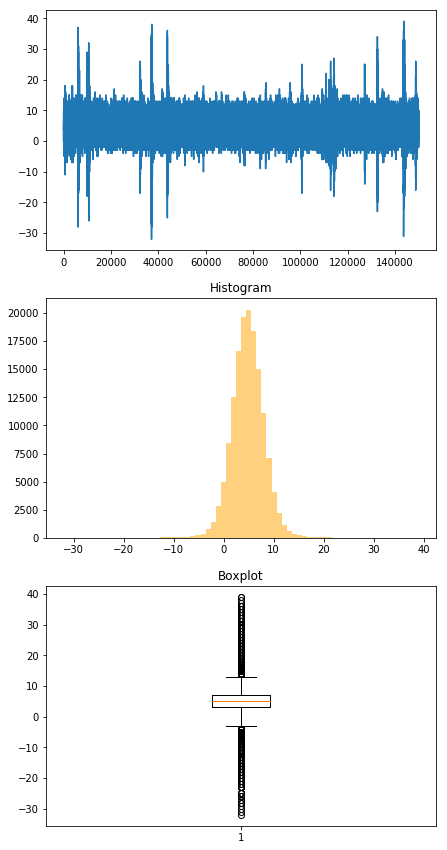

In [4]:
gen_plots(LANL_train_array)

The data we are using right represents only a single intance wich is a time segment with only one label. With this instance we might neeed to do some feature engeneering. Let's see some example of qualities we can get from the instance and its label. From this data, I concluded that we can use the mean of all the failure times from the instance as the single label for the instance.

In [5]:
print("Mean: ", LANL_mean)
print("Standard deviation: ", LANL_std)
print("Variance: ", LANL_variance)
print("Time to failure mean: ", np.mean(LANL_train_labels))
print("Max time to failure: ", np.max(LANL_train_labels))
print("Min time to failure: ", np.min(LANL_train_labels))

Mean:  4.823313333333333
Standard deviation:  3.420676612673126
Variance:  11.701028488488891
Time to failure mean:  6.578145552563556
Max time to failure:  6.5978965321
Min time to failure:  6.558598240399999


We can see we are starting to make new features for this instance, let's save it in a pandas dataframe 

In [6]:
features = np.array([LANL_mean, LANL_std, LANL_variance])
LANL_train = pd.DataFrame({'mean' : [features[0]], 'deviation' : [features[1]], 'variance' : features[2]})

In [7]:
LANL_train

,mean,deviation,variance
0,4.823313,3.420677,11.701028


Now we have a nice way to store all the features for each instance. But it seems a bit deorganized and once we start adding functions and features it will get more complicated; so let's make a simple pipeline to automatize all the process. For this I created a list of functions to make each feature and an estimator that applies each function to the instance

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew, kurtosis

cv =  lambda x: np.std(x) / np.mean(x)

# feature functions
feature_names = ['mean', 'deviation', 'variance', 
                 'min', 'max', 'skewness',
                 'kurtosis', 'quantile_25', 'quantile_50',
                 'quantile_75', 'coeficient__of_variation']
feature_trans = {'mean' : np.mean, 'deviation' : np.std, 'variance' : np.var, 
                 'min' : np.min, 'max' : np.max, 'skewness' : skew,
                 'kurtosis' : kurtosis, 'quantile' : np.percentile, 'coeficient__of_variation' : cv}

class FeatureGenerator(BaseEstimator, TransformerMixin):
   
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for name in feature_trans:
            if name == 'quantile':
                features.append(feature_trans[name](X, 25))
                features.append(feature_trans[name](X, 50))
                features.append(feature_trans[name](X, 75))
            else:
                features.append(feature_trans[name](X))
        return np.c_[features]

Now let's generate the features for all the instances in the dataset. The following function automates all the process from getting the data, appaying the function and finally normalazing it. 

In [26]:
from sklearn.preprocessing import StandardScaler

def GetTrainInstances(max_inst, directory=TRAIN_DIR, normalize=True):
    LANL_X = []
    LANL_y = []
    i = 0

    gen = FeatureGenerator()
    scaler = StandardScaler()
    
    max_instances = max_inst
    for file in train_files:
        if i == max_instances:
            break

        tmp = pd.read_csv(os.path.join(directory, file))
        tmp_data = np.array(tmp['acoustic_data'])
        tmp_labels = np.array(tmp['time_to_failure'])
        LANL_X.append(gen.fit_transform(tmp_data))
        # for all time instances we get the mean
        LANL_y.append(np.mean(tmp_labels)) 
        i += 1
    if normalize:
        LANL_X = scaler.fit_transform(np.array(LANL_X).reshape(max_instances, len(feature_names)))
    LANL_X = pd.DataFrame(np.array(LANL_X).reshape(max_instances, len(feature_names)), columns=feature_names)
    LANL_y = pd.DataFrame(np.array(LANL_y).reshape(max_instances, 1), columns=['time_to_failure'])
    LANL_X.to_csv(os.path.join(directory, "train_data.csv"), sep=',', encoding='utf-8', index=False)
    LANL_y.to_csv(os.path.join(directory, "train_labels.csv"), sep=',', encoding='utf-8', index=False)
    return LANL_X, LANL_y
            
    

In [27]:
LANL_X, LANL_y = GetTrainInstances(max_inst=200, normalize=False)

In [28]:
LANL_X = pd.read_csv(os.path.join(TRAIN_DIR, "train_data.csv"))
LANL_y = pd.read_csv(os.path.join(TRAIN_DIR, "train_labels.csv"))

For now I only loaded 200 instances of the dataset because it is easier to work with. When we start training the model I will include all the dataset

In [30]:
LANL_X.head()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,coeficient__of_variation
0,4.422187,3.780321,14.290825,-66.0,70.0,-0.046680,28.369833,2.0,4.0,6.0,0.854853
1,4.493220,4.994745,24.947474,-80.0,103.0,0.036164,21.434687,2.0,4.0,7.0,1.111618
2,4.733567,125.620611,15780.537980,-2699.0,2951.0,0.503524,130.496160,0.0,5.0,10.0,26.538258
3,4.620747,4.154216,17.257514,-72.0,98.0,-0.095299,28.962673,3.0,5.0,7.0,0.899036
4,4.278367,3.637338,13.230225,-86.0,111.0,0.246607,48.889263,2.0,4.0,6.0,0.850170


Now let's try to find out more information about the dataset looking at the correlation of the features

In [31]:
LANL_X.corr()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,coeficient__of_variation
mean,1.000000,0.075027,0.065674,-0.081726,0.073511,0.039009,0.107496,0.445906,0.801363,0.537295,0.043580
deviation,0.075027,1.000000,0.970883,-0.982689,0.944820,0.239904,0.309859,-0.378055,0.032728,0.475736,0.999245
variance,0.065674,0.970883,1.000000,-0.930091,0.860018,0.195681,0.202585,-0.350086,0.047031,0.443746,0.965811
min,-0.081726,-0.982689,-0.930091,1.000000,-0.968294,-0.235444,-0.451237,0.354422,-0.040998,-0.451942,-0.983573
max,0.073511,0.944820,0.860018,-0.968294,1.000000,0.351226,0.460183,-0.294379,0.022891,0.381275,0.950184
skewness,0.039009,0.239904,0.195681,-0.235444,0.351226,1.000000,0.260637,-0.027052,0.046493,0.040409,0.244670
kurtosis,0.107496,0.309859,0.202585,-0.451237,0.460183,0.260637,1.000000,-0.016196,0.116686,0.154731,0.313613
quantile_25,0.445906,-0.378055,-0.350086,0.354422,-0.294379,-0.027052,-0.016196,1.000000,0.452045,-0.070777,-0.388945
quantile_50,0.801363,0.032728,0.047031,-0.040998,0.022891,0.046493,0.116686,0.452045,1.000000,0.415262,0.005998
quantile_75,0.537295,0.475736,0.443746,-0.451942,0.381275,0.040409,0.154731,-0.070777,0.415262,1.000000,0.458700
